# Classification on the Telco-churn dataset

#### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline

#### Loading the data

In [3]:
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

#### Let's visualize the univariate distribution of each continuous feature, and the distribution of the target.

In [4]:
continuous = ['tenure', 'MonthlyCharges', 'TotalCharges']

In [5]:
target = 'Churn'

I notice that some NA values in `TotalCharges` are coded as blank spaces and prevent correct parsing of the column to build its histogram. I code them appropriately before going forward:

In [6]:
data = data.replace(to_replace = {'TotalCharges': ' '}, value = np.NaN)

In [7]:
data['TotalCharges'] = data['TotalCharges'].astype(float)

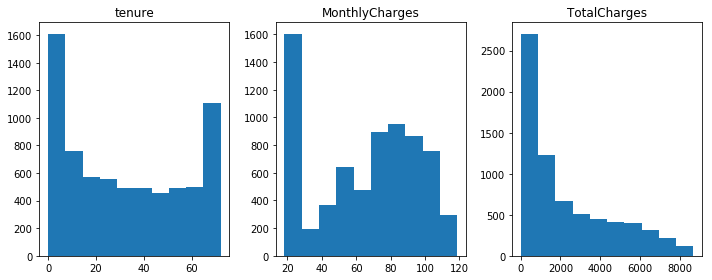

In [8]:
# plotting without the NaN values
f, ax = plt.subplots(1, 3, figsize=(10, 4))
for i in range(3):
    var_name = continuous[i]
    var_not_nan = data.loc[~np.isnan(data[var_name]), var_name]
    ax[i].hist(var_not_nan)
    ax[i].set_title(var_name)
plt.tight_layout()

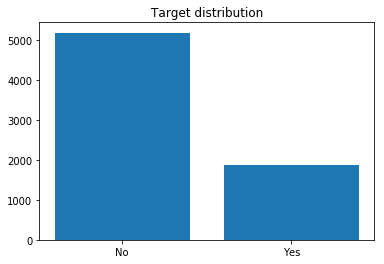

In [9]:
plt.bar(x = ['No', 'Yes'], height = data[target].value_counts())
plt.title('Target distribution')
plt.show()

We have a bit of an imbalance in the target classes here but it could be worse.

#### Let's split the data into training and test sets. Then we build a pipeline for dealing with categorical variables and evaluate Logistic Regression, linear support vector machines and nearest centroids models using cross-validation. We also study the influence of scaling the continuous features.

In [10]:
# encoding target with 0/1
data = data.replace(to_replace={'Churn': 'Yes'}, 
                      value=1)
data = data.replace(to_replace={'Churn': 'No'}, 
                      value=0)

In [11]:
X = data.drop(labels=['customerID', 'Churn'], axis=1)

*Splitting data intro training and test set:*

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
train, test, y_train, y_test = train_test_split(X, data[target], random_state=0)

*Building a pipeline to deal with categorical features:*

In [14]:
categorical = list(set(train.columns) - set(continuous) - {'customerID'})

In [15]:
train = train.replace(to_replace={var:np.NaN for var in categorical}, 
                      value="N/A")

In [16]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer

I impute values of `TotalCharges` using median imputation:

In [17]:
cat_encoder = OneHotEncoder(categories=[train[var].unique() for var in categorical])
cont_imputer = SimpleImputer(strategy='median')
preprocess = make_column_transformer((continuous, cont_imputer), 
                                     (categorical, cat_encoder))

*Instantiating the models with default parameters:*

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import NearestCentroid

In [19]:
# setting the solver to avoid future warnings
log_reg = LogisticRegression(solver='lbfgs')
svm = LinearSVC()
near_cent = NearestCentroid()

*Evaluation with cross-validation:*

**Faced with a little class imbalance we used F1 score to evaluate our algorithms**

In [20]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

In [21]:
import warnings

In [22]:
scores = []
model_log = make_pipeline(preprocess, log_reg)
model_svm = make_pipeline(preprocess, svm)
model_cen = make_pipeline(preprocess, near_cent)
# to avoid convergence warnings popping up
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cross_v_log = cross_val_score(model_log, train, y_train, cv=5, scoring='f1')
    cross_v_svm = cross_val_score(model_svm, train, y_train, cv=5, scoring='f1')
    cross_v_cen = cross_val_score(model_cen, train, y_train, cv=5, scoring='f1')
scores.append(cross_v_log.mean())
scores.append(cross_v_svm.mean())
scores.append(cross_v_cen.mean())

In [23]:
table = pd.DataFrame({'Scores': np.around(scores, decimals=3)},
                      index=['LogisticRegression', 'SVM', 'NearestCentroid'])
display(table)

,Scores
LogisticRegression,0.605
SVM,0.424
NearestCentroid,0.448


**We get a 0.61 F1-score for `LogisticRegression` and significantly lower scores for other models.**

*Now with scaling for continuous features:*

In [24]:
from sklearn.preprocessing import StandardScaler

In [25]:
cont_scaler = StandardScaler()
cont_pipe = make_pipeline(cont_imputer, cont_scaler)
prepro_scaled = make_column_transformer((continuous, cont_pipe), 
                                        (categorical, cat_encoder))

In [26]:
scores_scaled = []
model_log_scaled = make_pipeline(prepro_scaled, log_reg)
model_svm_scaled = make_pipeline(prepro_scaled, svm)
model_cen_scaled = make_pipeline(prepro_scaled, near_cent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cross_v_log_s = cross_val_score(model_log_scaled, train, y_train, 
                                    cv=5, scoring='f1')
    cross_v_svm_s = cross_val_score(model_svm_scaled, train, y_train, 
                                    cv=5, scoring='f1')
    cross_v_cen_s = cross_val_score(model_cen_scaled, train, y_train, 
                                    cv=5, scoring='f1')
scores_scaled.append(cross_v_log_s.mean())
scores_scaled.append(cross_v_svm_s.mean())
scores_scaled.append(cross_v_cen_s.mean())

In [27]:
table = pd.DataFrame({'Scores': np.around(scores_scaled, decimals=3)},
                      index=['LogisticRegression', 'SVM', 'NearestCentroid'])
display(table)

,Scores
LogisticRegression,0.605
SVM,0.597
NearestCentroid,0.621


**The results have significantly improved for `SVM` and `NearestCentroid` with `SVM` achieving 0.62 F1 score on the validation sets. `LogisticRegression` maintains a 0.61 score.**

#### Let's tune the parameters using grid search. Then we visualize the performance as function of the parameters for all three models.

In [28]:
from sklearn.model_selection import GridSearchCV

*Instantiating the parameter grids:*

In [29]:
param_grid_log = {'logisticregression__C': np.logspace(-3, 3, 7)}
param_grid_svm = {'linearsvc__C': np.logspace(-3, 3, 7)}
param_grid_cen = {'nearestcentroid__shrink_threshold': np.linspace(0, 20., 11)}

Running the grid searches with scaled input:

In [30]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    grid_log = GridSearchCV(model_log_scaled, param_grid_log, 
                            cv=5, scoring='f1').fit(train, y_train)
    grid_svm = GridSearchCV(model_svm_scaled, param_grid_svm, 
                            cv=5, scoring='f1').fit(train, y_train)
    grid_cen = GridSearchCV(model_cen_scaled, param_grid_cen, 
                            cv=5, scoring='f1').fit(train, y_train)

*Fetching the validation scores:*

In [31]:
score_log = grid_log.cv_results_['mean_test_score']
score_svm = grid_svm.cv_results_['mean_test_score']
score_cen = grid_cen.cv_results_['mean_test_score']

*Checking the best parameters as well as the best validation scores:*

In [32]:
print("The best logistic regression regularization parameter is " 
      + str(grid_log.best_params_['logisticregression__C']))
print("The best logistic regression validation score is %.4f"
      %grid_log.best_score_)
print("The previous validation score (with default parameters) was %.4f"
      %table.iloc[0, :])

The best logistic regression regularization parameter is 100.0
The best logistic regression validation score is 0.6052
The previous validation score (with default parameters) was 0.6050


In [33]:
print("The best SVM regularization parameter is "
      + str(grid_svm.best_params_['linearsvc__C']))
print("The best SVM validation score is %.4f"
      %grid_svm.best_score_)
print("The previous validation score (with default parameters) was %.4f"
      %table.iloc[1, :])

The best SVM regularization parameter is 1.0
The best SVM validation score is 0.5971
The previous validation score (with default parameters) was 0.5970


In [34]:
1/len(X.columns)

0.05263157894736842

In [35]:
print("The best nearest centroid shrinking threshold is " 
      + str(grid_cen.best_params_['nearestcentroid__shrink_threshold']))
print("The best nearest centroid validation score is %.4f"
      %grid_cen.best_score_)
print("The previous validation score (with default parameters) was %.4f"
      %table.iloc[2, :])

The best nearest centroid shrinking threshold is 0.0
The best nearest centroid validation score is 0.6211
The previous validation score (with default parameters) was 0.6210


**The results for all models only slightly improved with the grid search. This suggests we either haven't covered the most promising ranges of values for the hyperparameters or that the data's predictive power is limited.**

I plot the dependency of the validation score on the parameters for all models:

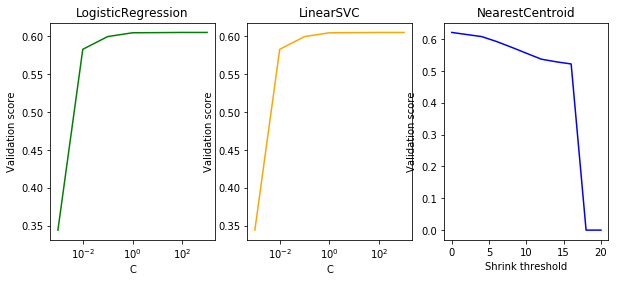

In [36]:
f, ax = plt.subplots(1, 3, figsize=(10, 4))

ax[0].plot(np.logspace(-3, 3, 7), score_log, color = "green")
ax[0].set_xscale('log')
ax[0].set_ylabel("Validation score")
ax[0].set_xlabel("C")
ax[0].set_title("LogisticRegression")

ax[1].plot(np.logspace(-3, 3, 7), score_log, color = "orange")
ax[1].set_xscale('log')
ax[1].set_ylabel("Validation score")
ax[1].set_xlabel("C")
ax[1].set_title("LinearSVC")

ax[2].plot(np.linspace(0, 20., 11), score_cen, color = "blue")
ax[2].set_ylabel("Validation score")
ax[2].set_xlabel("Shrink threshold")
ax[2].set_title("NearestCentroid")

plt.show()

#### Let's change the cross-validation strategy from ‘stratified k-fold’ to ‘kfold’ with shuffling. Do the parameters that are found change? Do they change if I change the random seed of the shuffling? Or if I change the random state of the split into training and test data?

*Checking if the parameters change with `KFold` with shuffling:*

In [37]:
from sklearn.model_selection import KFold

In [38]:
kfold = KFold(n_splits=5, shuffle=True, random_state = 0)

In [39]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    grid_log_2 = GridSearchCV(model_log_scaled, param_grid_log, 
                              cv=kfold, scoring='f1').fit(train, y_train)
    grid_svm_2 = GridSearchCV(model_svm_scaled, param_grid_svm, 
                              cv=kfold, scoring='f1').fit(train, y_train)
    grid_cen_2 = GridSearchCV(model_cen_scaled, param_grid_cen, 
                              cv=kfold, scoring='f1').fit(train, y_train)

In [40]:
print("The best logistic regression regularization parameter with shuffling is " 
      + str(grid_log_2.best_params_['logisticregression__C']))
print("The best logistic regression validation score with shuffling is %.4f"
      %grid_log_2.best_score_)
print("The best logistic regression regularization parameter without shuffling is " 
      + str(grid_log.best_params_['logisticregression__C']))
print("The best logistic regression validation score without shuffling is %.4f"
      %grid_log.best_score_)

The best logistic regression regularization parameter with shuffling is 1.0
The best logistic regression validation score with shuffling is 0.6057
The best logistic regression regularization parameter without shuffling is 100.0
The best logistic regression validation score without shuffling is 0.6052


In [41]:
print("The best SVM regularization parameter with shuffling is " 
      + str(grid_svm_2.best_params_['linearsvc__C']))
print("The best SVM validation score with shuffling is %.4f"
      %grid_svm_2.best_score_)
print("The best SVM regularization parameter without shuffling is "
      + str(grid_svm.best_params_['linearsvc__C']))
print("The best SVM validation score without shuffling is %.4f"
      %grid_svm.best_score_)

The best SVM regularization parameter with shuffling is 1.0
The best SVM validation score with shuffling is 0.5976
The best SVM regularization parameter without shuffling is 1.0
The best SVM validation score without shuffling is 0.5971


In [42]:
print("The best nearest centroid shrinking threshold with shuffling is " 
      + str(grid_cen_2.best_params_['nearestcentroid__shrink_threshold']))
print("The best nearest centroid validation score with shuffling is %.4f"
      %grid_cen_2.best_score_)
print("The best nearest centroid shrinking threshold without shuffling is " 
      + str(grid_cen.best_params_['nearestcentroid__shrink_threshold']))
print("The best nearest centroid validation score without shuffling is %.4f"
      %grid_cen.best_score_)

The best nearest centroid shrinking threshold with shuffling is 0.0
The best nearest centroid validation score with shuffling is 0.6192
The best nearest centroid shrinking threshold without shuffling is 0.0
The best nearest centroid validation score without shuffling is 0.6211


**The parameters have not changed for `SVM` and `NearestCentroid`. The regularization parameter for `LogisticRegression` has significantly changed.** 

*Checking if the parameters change with the random seed:*

In [43]:
C_log = []
C_svm = []
shrink_cen = []
n_exp = 20
for i in range(n_exp):
    kfold = KFold(n_splits=5, shuffle=True, random_state=i)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        grid_log_2 = GridSearchCV(model_log_scaled, param_grid_log, 
                                  cv=kfold, scoring='f1').fit(train, y_train)
        grid_svm_2 = GridSearchCV(model_svm_scaled, param_grid_svm, 
                                  cv=kfold, scoring='f1').fit(train, y_train)
        grid_cen_2 = GridSearchCV(model_cen_scaled, param_grid_cen, 
                                  cv=kfold, scoring='f1').fit(train, y_train)
    C_log.append(grid_log_2.best_params_['logisticregression__C'])
    C_svm.append(grid_svm_2.best_params_['linearsvc__C'])
    shrink_cen.append(grid_cen_2.best_params_['nearestcentroid__shrink_threshold'])

In [44]:
C_log, counts_C_log = np.unique(C_log, return_counts=True)
C_svm, counts_C_svm = np.unique(C_svm, return_counts=True)
shrink_cen, counts_shrink_cen = np.unique(shrink_cen, return_counts=True)

Let us show the proportion of each value of the best parameters retained by each model over the different grid searches:

In [45]:
res_log = pd.DataFrame({'C': C_log,
                        'Proportion': counts_C_log/n_exp})
res_svm = pd.DataFrame({'C': C_svm,
                        'Proportion': counts_C_svm/n_exp})
res_cen = pd.DataFrame({'Shrink threshold': shrink_cen,
                        'Proportion': counts_shrink_cen/n_exp})

In [46]:
display(res_log)

,C,Proportion
0,1.0,0.35
1,10.0,0.15
2,100.0,0.30
3,1000.0,0.20


In [47]:
display(res_svm)

,C,Proportion
0,0.1,0.20
1,1.0,0.25
2,10.0,0.55


In [48]:
display(res_cen)

,Shrink threshold,Proportion
0,0.0,1.0


**Visibly changing the random seed in the shuffle procedure changes the preferred parameter for `LogisticRegression` and `SVM` quite significantly. It only selects a zero shrink threshold for `NearestCentroid` (which might suggest the range of thresholds tried is inappropriate, rather than the model's variance is very low).**

*Checking if changing the random seed of the `train_test_split` changes the best parameters:*

In [49]:
C_log = []
C_svm = []
shrink_cen = []
for i in range(n_exp):
    train2, _, y_train2, _ = train_test_split(data, 
                                              data[target], 
                                              random_state=i)
    train2 = train2.replace(to_replace={var:np.NaN for var in categorical}, 
                            value="N/A")
    train2 = train2.drop(labels=['customerID'], axis=1)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        grid_log_2 = GridSearchCV(model_log_scaled, param_grid_log, 
                                  cv=5, scoring='f1').fit(train2, y_train2)
        grid_svm_2 = GridSearchCV(model_svm_scaled, param_grid_svm, 
                                  cv=5, scoring='f1').fit(train2, y_train2)
        grid_cen_2 = GridSearchCV(model_cen_scaled, param_grid_cen, 
                                  cv=5, scoring='f1').fit(train, y_train2)
    C_log.append(grid_log_2.best_params_['logisticregression__C'])
    C_svm.append(grid_svm_2.best_params_['linearsvc__C'])
    shrink_cen.append(grid_cen_2.best_params_['nearestcentroid__shrink_threshold'])

In [50]:
C_log, counts_C_log = np.unique(C_log, return_counts=True)
C_svm, counts_C_svm = np.unique(C_svm, return_counts=True)
shrink_cen, counts_shrink_cen = np.unique(shrink_cen, return_counts=True)

In [51]:
res_log = pd.DataFrame({'C': C_log,
                        'Proportion': counts_C_log/n_exp})
res_svm = pd.DataFrame({'C': C_svm,
                        'Proportion': counts_C_svm/n_exp})
res_cen = pd.DataFrame({'Shrink threshold': shrink_cen,
                        'Proportion': counts_shrink_cen/n_exp})

In [52]:
display(res_log)

,C,Proportion
0,1.0,0.20
1,10.0,0.45
2,100.0,0.30
3,1000.0,0.05


In [53]:
display(res_svm)

,C,Proportion
0,0.1,0.15
1,1.0,0.40
2,10.0,0.45


In [54]:
display(res_cen)

,Shrink threshold,Proportion
0,0.0,1.0


Same conclusion as last computations.

#### Let's visualize the coefficients for LogisticRegression and Linear Support Vector Machines using hyper-parameters that performed well in the grid-search.

*Visualizing the top-20 coefficients for both models*:

In [55]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    log_best = make_pipeline(prepro_scaled, 
                             LogisticRegression(C=100, 
                                                solver='lbfgs')).fit(train, 
                                                                     y_train)
    svm_best = make_pipeline(prepro_scaled, 
                             LinearSVC(C=10)).fit(train, y_train)

In [56]:
log_coef = log_best.named_steps['logisticregression'].coef_[0]
svm_coef = svm_best.named_steps['linearsvc'].coef_[0]

In [57]:
log_indices = np.argsort(-np.absolute(log_coef))[:20]
svm_indices = np.argsort(-np.absolute(svm_coef))[:20]

In [58]:
log_largest_coef = log_coef[log_indices]
svm_largest_coef = svm_coef[svm_indices]

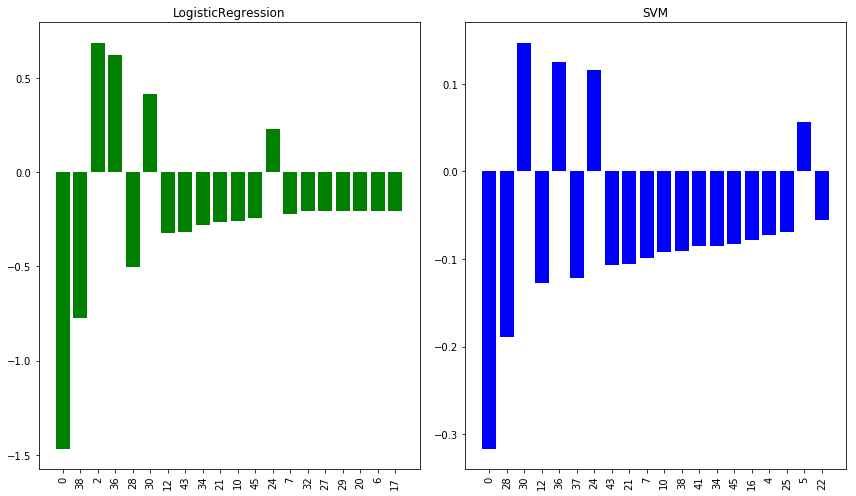

In [59]:
f, ax = plt.subplots(1, 2, figsize=(12, 7))

ax[0].bar(range(1, 21), log_largest_coef, color = "green")
ax[0].set_xticks(range(1, 21))
ax[0].set_xticklabels(log_indices, rotation = 90)
ax[0].set_title("LogisticRegression")

ax[1].bar(range(1, 21), svm_largest_coef, color = "blue")
ax[1].set_xticks(range(1, 21))
ax[1].set_xticklabels(svm_indices, rotation = 90)
ax[1].set_title("SVM")

plt.tight_layout()
plt.show()